# Mini-project IIIb: Bayesian Neural Networks

**Answer questions and do tasks written in boldface.**

Based on the [demo-Bayesian_neural_networks_tif285.ipynb](https://furnstahl.github.io/Physics-8820/notebooks/Machine_learning/demo-Bayesian_neural_networks_tif285.html) notebook by Christian Forssén, which in turn was based on:

## Variational Inference: Bayesian Neural Networks

(c) 2016-2018 by Thomas Wiecki, updated by Maxim Kochurov.

Original blog post: https://twiecki.github.io/blog/2016/06/01/bayesian-deep-learning/
and updated version: https://docs.pymc.io/notebooks/bayesian_neural_network_advi.html.

This mini-project relies on the following additional packages:
* `theano`: Theano is a Python library that allows you to define, optimize, and evaluate mathematical expressions involving multi-dimensional arrays efficiently, featuring tight integration with NumPy, transparent use of a GPU, efficient symbolic differentiation, speed and stability optimizations and dynamic C code generation.
* `pymc3`: PyMC3 is a library for probabilistic programming in python. It allows you to write down models using an intuitive syntax to describe a data generating process.
* `arviz`: ArviZ (pronounced "AR-vees") is a Python package for exploratory analysis of Bayesian models. Includes functions for posterior analysis, model checking, comparison and diagnostics.

This should work with conda environments using the original environment.yml conda file on Macs and Linux machines or using the environment_windows.yml conda file on Windows 10.


## Generating data

First, lets generate some toy data -- a simple binary classification problem that's not linearly separable. Here we use `make_moons` from scikit-learn to generate the full set of data (see https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) and `train_test_split` to divide it into training and test sets (see https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(); sns.set_context("talk")

from warnings import filterwarnings
filterwarnings('ignore')

import sklearn
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons, make_circles

In [2]:
# Import theano and pymc3

# suppress some theano compilation errors with MacOSX clang compiler
import theano
# CF added (https://stackoverflow.com/questions/51238578/error-non-constant-expression-cannot-be-narrowed-from-type-npy-intp-to-int)
theano.config.gcc.cxxflags = "-Wno-c++11-narrowing"  # Is this is really necessary?
floatX = theano.config.floatX
import pymc3 as pm
import theano.tensor as T

In [3]:
# Create combined training and test data.  For other examples, see
#  https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html
X, Y = make_moons(noise=0.2, random_state=2, n_samples=1000)
X = scale(X)
X = X.astype(floatX)
Y = Y.astype(floatX)

# Split into training and test data. test_size is proportion in test data.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5, 
                                                    random_state=0)

**To do: add code here to plot the training and test data in the empty two plots below.**

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18,6))

ax[0].scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
ax[0].scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
ax[0].legend()
sns.despine(); 
ax[0].set(xlabel='X1', ylabel='X2', title='Toy binary classification data set')

ax[1].set(xlabel='X1', ylabel='X2', title='Training data set')
ax[1].scatter(X_train[Y_train==0, 0], X_train[Y_train==0, 1], label='Class 0')
ax[1].scatter(X_train[Y_train==1, 0], X_train[Y_train==1, 1], color='r', label='Class 1')
ax[1].legend()

ax[2].set(xlabel='X1', ylabel='X2', title='Test data set')
ax[2].scatter(X_test[Y_test==0, 0], X_test[Y_test==0, 1], label='Class 0')
ax[2].scatter(X_test[Y_test==1, 0], X_test[Y_test==1, 1], color='r', label='Class 1')
ax[2].legend()

fig.tight_layout()

## Model specification

A neural network is quite simple. The basic unit is a [perceptron](https://en.wikipedia.org/wiki/Perceptron), which is nothing more than [logistic regression](http://pymc-devs.github.io/pymc3/notebooks/posterior_predictive.html#Prediction). We use many of these in parallel and then stack them up to get hidden layers. Here we start with 2 hidden layers with 5 neurons each which is sufficient for such a simple problem.

In [5]:
def construct_nn(ann_input, ann_output):
    n_hidden = 5   # this is the number of neurons, not hidden layers

    # Initialize random weights between each layer
    init_1 = np.random.randn(X.shape[1], n_hidden).astype(floatX)
    init_1b = 0.1*np.random.randn() #comment out to remove bias term
    init_2 = np.random.randn(n_hidden, n_hidden).astype(floatX)
    init_2b = 0.1*np.random.randn()#comment out to remove bias term
    init_out = np.random.randn(n_hidden).astype(floatX)
    init_outb = 0.1*np.random.randn()#comment out to remove bias term

    with pm.Model() as neural_network:
        # Trick: Turn inputs and outputs into shared variables using the data 
        # container pm.Data.  It's still the same thing, but we can later 
        # change the values of the shared variable (to switch in the test-data 
        # later) and pymc3 will just use the new data. Like a pointer we can redirect.
        # For more info, see: http://deeplearning.net/software/theano/library/compile/shared.html
        ann_input = pm.Data('ann_input', X_train)
        ann_output = pm.Data('ann_output', Y_train)

        # Weights from input to 1st hidden layer
        bias_in_1 = pm.Normal('b_in_1', 0, sigma=10, testval=init_1b)#comment out to remove bias term
        weights_in_1 = pm.Normal('w_in_1', 0, sigma=1,
                                 shape=(X.shape[1], n_hidden),
                                 testval=init_1)

        # Weights from 1st to 2nd layer
        bias_1_2 = pm.Normal('b_1_2', 0, sigma=10, testval=init_2b)#comment out to remove bias term
        weights_1_2 = pm.Normal('w_1_2', 0, sigma=1,
                                shape=(n_hidden, n_hidden),
                                testval=init_2)

        # Weights from 2nd hidden layer to output
        bias_2_out = pm.Normal('b_2_out', 0, sigma=10, testval=init_outb)#comment out to remove bias term
        weights_2_out = pm.Normal('w_2_out', 0, sigma=1,
                                  shape=(n_hidden,),
                                  testval=init_out)

        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh( pm.math.dot(ann_input, weights_in_1) + bias_in_1) #remove bias term if you dont want it
        act_2 = pm.math.tanh( pm.math.dot(act_1, weights_1_2) + bias_1_2)#remove bias term if you dont want it
        act_out = pm.math.sigmoid( pm.math.dot(act_2, weights_2_out) + bias_2_out)#remove bias term if you dont want it

        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli('out',
                           act_out,
                           observed=ann_output,
                           total_size=Y_train.shape[0] # IMPORTANT for minibatches
                          )
    return neural_network

neural_network = construct_nn(X_train, Y_train)

The `Normal` priors help regularize the weights. Usually we would add a constant `b` to the inputs (come back to do this later).

## Variational Inference: Scaling model complexity

To find a posterior for the weights, we will use [ADVI](https://arxiv.org/abs/1603.00788) variational inference algorithm in PyMC3. This is much faster than an MCMC sampler and will scale better.

**Note**, however, that this is a mean-field approximation so we **ignore correlations** in the posterior.

In [6]:
from pymc3.theanof import set_tt_rng
np.random.seed(42)
set_tt_rng(42)


In [7]:
%%time

# Run the ADVI inference for n iterations.
with neural_network:
    inference = pm.ADVI()
    approx = pm.fit(n=60000, method=inference)

Finished [100%]: Average Loss = 112.3


CPU times: user 4min 53s, sys: 17.6 s, total: 5min 11s
Wall time: 6min 18s


Plotting the objective function (ELBO) shows us how the optimization of the fit improves over time.

In [8]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(-inference.hist, label='new ADVI', alpha=.3)
ax.legend()
ax.set_ylabel('ELBO')
ax.set_xlabel('iteration')
plt.tight_layout;

Now that we have trained our model, lets predict on the hold-out (i.e., test) set using a posterior predictive check (PPC). 
1. We can use `sample_posterior_predictive() <../api/inference.rst>`__ to generate new data (in this case class predictions) from the posterior (sampled from the variational estimation).
1. It is better to get the node directly and build theano graph using our approximation (approx.sample_node) , we get a lot of speed up.  We'll use this method below.

In [9]:
# We can get predicted probability from model
neural_network.out.distribution.p

sigmoid.0

In [10]:
# create symbolic input in theano
x = T.matrix('X')
# symbolic number of samples is supported, we build vectorized posterior on the fly
n = T.iscalar('n')
# Do not forget test_values or set theano.config.compute_test_value = 'off'
x.tag.test_value = np.empty_like(X_train[:10])
n.tag.test_value = 100
_sample_proba = approx.sample_node(neural_network.out.distribution.p,
                                   size=n,
                                   more_replacements={neural_network['ann_input']: x})
# It is time to compile the function
# No updates are needed for Approximation random generator
# Efficient vectorized form of sampling is used
sample_proba = theano.function([x, n], _sample_proba)

# Let’s go ahead and generate predictions (using method 2 from above):
pred = sample_proba(X_test, 500).mean(0) > 0.5


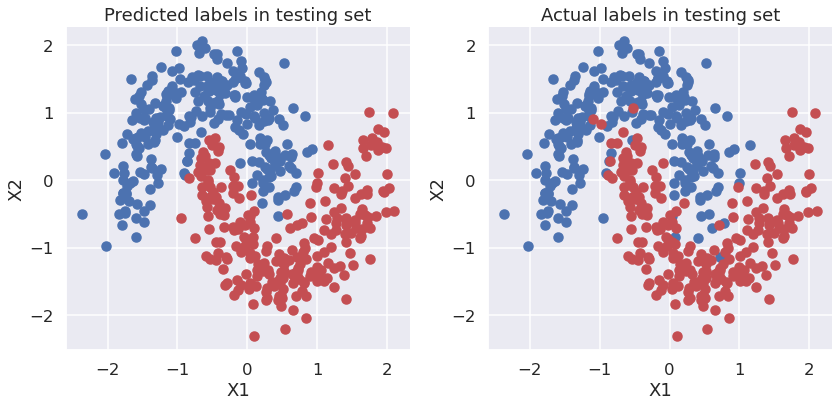

In [11]:
# Make plots of predicted and actual labels
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
ax[0].scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax[0].scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
sns.despine()
ax[0].set(title='Predicted labels in testing set', xlabel='X1', ylabel='X2');

ax[1].scatter(X_test[Y_test==0, 0], X_test[Y_test==0, 1])
ax[1].scatter(X_test[Y_test==1, 0], X_test[Y_test==1, 1], color='r')
sns.despine()
ax[1].set(title='Actual labels in testing set', xlabel='X1', ylabel='X2');


fig.tight_layout()

In [12]:
# accuracy of predictions
print(f'Accuracy = {(Y_test == pred).mean() * 100}')

Accuracy = 95.39999999999999


## Let's look at what the classifier has learned

For this, we evaluate the class probability predictions on a grid over the whole input space.

In [13]:
grid = pm.floatX(np.mgrid[-3:3:100j,-3:3:100j])
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)

In [14]:
ppc = sample_proba(grid_2d ,500)

### Probability surface

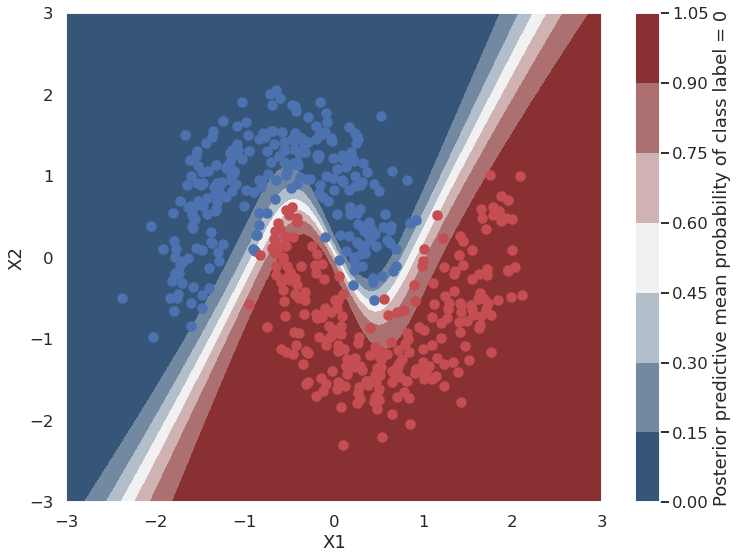

In [15]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(12, 9))
contour = ax.contourf(grid[0], grid[1], ppc.mean(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X1', ylabel='X2');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

**What is being plotted in this graph?  How does it compare to what you would get from a non-Bayesian neural network?**
<br><br>
What is being plotted are the points that are in a region of probabily larger than 0.5 get labeled red otherwise labeled blue. As well, we get plotted the regions of probability that data in said region is of a certain type.
We obtain a probability of the data point being in a class rather than a definite answer.

### Uncertainty in predicted value

**What is being plotted below?  Why is this different from a non-Bayesian neural network?**
<br><br>
What is plotted here are the regions of uncertainty. This tells us that while we have labeled our data, that there is some uncertainty on how likely it is correct.
Nonbayesian neural network wouldnt give use that

In [16]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(12, 9))
contour = ax.contourf(grid[0], grid[1], ppc.std(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X1', ylabel='X2');
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)');

## To do

**For each of the parameter choices listed below, do the following:** 

**a. Predict from the training and test data plots how well the Bayesian neural network should do (e.g., compared to the other parameter choices).**

**b. Record the Average Loss.  Does the optimization appear to be converged?** 

**c. Record the accuracy.  Is the value consistent with your expectations from a.?**

**d. What does the "uncertainty in predicted value" figure tell you about where the uncertainty in picking a label (red or blue) is greatest for this case?  Consider both regions where there is a lot of training data and where there is no training data.  Why does this make sense given your expectations from a.?**


### Parameter choices

#### 1. `n_samples = 1000`, `noise = 0.2`, `test_size = 0.5`, iterations `n = 30000`

    a. I would expect that there are not enough iterations to find the boundary for the centers (like -1 to 1 region for x1 and x2). It will be a half circle like shape for each label

    b. Average loss is 164.88, It does not look like it has converages as there is still relatively large fluctuations in ELBO during the last few thousand iterations 

    c. The accuracy is 89.60 which is what I was expecting. When looking at the predicted labels in testing set plot, I am able to see the error I was expecting.

    d.The uncertainty is greatest in regions where there was no training data and gets better in areas where there was training data. WHY DOES THIS MAKE SENSE GIVEN a?

#### 2. `n_samples = 1000`, `noise = 0.2`, `test_size = 0.5`, iterations `n = 60000`

    a. Compared to part 1, I think the amount of iterations will be suffice and it will be able to find the labels a lot better in the region between -1 to 1 for x1 and x2

    b. Average loss is 98.109, It does look like it has converaged or near convergence as the ELBO fluctuations are relatively small in the last few thousand iterations.

    c. The accuracy is 95.199 which is consistent to what I was expecting in part a as this accuracy is better than parameter choice 1

    d.The uncertainty is greatest in regions where there was no training data and gets better in areas where there was training data. As well, the uncertainty is pretty high at the boundary that divides the red class and the blue class. This make senses to my expectation as it was dividing up that region that i said it would have a better time figuring out that parameter choice 1

#### 3. `n_samples = 1000`, `noise = 0.05`, `test_size = 0.5`, iterations `n = 60000`

    a. I think it will definitely be able to to find both labels as there is a clear separation between red and blue and there is a gap between red and blue

    b. Average loss is 73.824, ELBO got small and fluctating from like -125 to -500 after about 10000 iterations so it may have converaged and then maybe overfitting

    c. Accuracy is 99.4 which is in agreement to what I was expecting in part a

    d. The uncertainty is greatest in regions where there was no training data and gets better in areas where there was training data. As well, the uncertainty is pretty high at the boundary that divides the red class and the blue class. This make senses to my expectation as it was dividing up that region, there is also a large uncertainty in the gaps between the labels as there is limited data there.

#### 4. `n_samples = 1000`, `noise = 0.5`, `test_size = 0.5`, iterations `n = 60000`

    a. There is so much noise that it is very unclear on there being a banana shape for the labels. It looks like each label is a circle and they overlap each other a decent amount. I do not think the network will perform well. It will probably create a dividor somewhere in that overlap

    b. Average loss is 240.01, ELBO has relatively small fluctuations around the last 20 thoursand itereations and looks like it converged. 

    c. Accuracy is 80.80 which is consitent with what I was expecting. Since the divide was somewhere in the overlap then it makes sense for the accuracy to be low.

    d. The uncertainty is greatest in regions where there was no training data and gets better in areas where there was training data. There is no gap between red and blue which is why uncertainty is relatively small compared to parameter choice 3
    

#### 5. `n_samples = 100`, `noise = 0.2`, `test_size = 0.5`, iterations `n = 60000`

    a. The data is too limited and sparse that there won't be any clear boundary. This will do the worse out of all parameter choices.

    b. The average loss is 34.283, ELBO is pretty small and fluctuates from -25 to -100. I think it won't converage as there isn't enough data

    c. The accuracy is 86.0 which is a little better than I was expecting as it has better accuracy than parameter choice 4. There probably isn't enough data to represent the banana shape so it for what it sees in the training was enough to do well for the testing set

    d. There is heavy uncertainty everywhere as we are limited on the amount of data. This makes sense given my expectations in part a
    


**Copy below the code for the `construct_nn` function that adds a third hidden layer to the neural network. Test it on one of the parameter choices above, and describe how the results b., c., and d. compare for two and three hidden layers.** 

In [17]:
### Copy code for construct_nn function with 3rd hidden layer



### Copy code for construct_nn function with 3rd hidden layer

def construct_nn(ann_input, ann_output):
    n_hidden = 5   # this is the number of neurons, not hidden layers

    # Initialize random weights between each layer
    init_1 = np.random.randn(X.shape[1], n_hidden).astype(floatX)
    init_2 = np.random.randn(n_hidden, n_hidden).astype(floatX)
    init_3 = np.random.randn(n_hidden, n_hidden).astype(floatX)
    init_out = np.random.randn(n_hidden).astype(floatX)

    with pm.Model() as neural_network:
        # Trick: Turn inputs and outputs into shared variables using the data 
        # container pm.Data.  It's still the same thing, but we can later 
        # change the values of the shared variable (to switch in the test-data 
        # later) and pymc3 will just use the new data. Like a pointer we can redirect.
        # For more info, see: http://deeplearning.net/software/theano/library/compile/shared.html
        ann_input = pm.Data('ann_input', X_train)
        ann_output = pm.Data('ann_output', Y_train)

        # Weights from input to 1st hidden layer
        weights_in_1 = pm.Normal('w_in_1', 0, sigma=1,
                                 shape=(X.shape[1], n_hidden),
                                 testval=init_1)

        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal('w_1_2', 0, sigma=1,
                                shape=(n_hidden, n_hidden),
                                testval=init_2)
        
        # Weights from 1st to 2nd layer
        weights_2_3 = pm.Normal('w_2_3', 0, sigma=1,
                                shape=(n_hidden, n_hidden),
                                testval=init_3)
        
        # Weights from 2nd hidden layer to output
        weights_3_out = pm.Normal('w_3_out', 0, sigma=1,
                                  shape=(n_hidden,),
                                  testval=init_out)

        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh( pm.math.dot(ann_input, weights_in_1) )
        act_2 = pm.math.tanh( pm.math.dot(act_1, weights_1_2) )
        act_3 = pm.math.tanh( pm.math.dot(act_2, weights_2_3) )
        act_out = pm.math.sigmoid( pm.math.dot(act_3, weights_3_out) )

        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli('out',
                           act_out,
                           observed=ann_output,
                           total_size=Y_train.shape[0] # IMPORTANT for minibatches
                          )
    return neural_network

neural_network = construct_nn(X_train, Y_train)





#### 2. `n_samples = 1000`, `noise = 0.2`, `test_size = 0.5`, iterations `n = 60000`

    a.I think the amount of iterations will be suffice and it will be able to find the labels a lot better in the region between -1 to 1 for x1 and x2. I fill like it would do better now that it has one more weights than the previous.

    b. Average loss is 122.42, it has a large amount of fluctuations and I would think it hasn't converged.

    c. The accuracy is 95.6 which is consistent to what I was expecting in part a. It was able to figure the region pretty well.

    d.The uncertainty is greatest in regions where there was no training data and gets better in areas where there was training data. As well, the uncertainty is pretty high at the boundary that divides the red class and the blue class. This make senses to my expectation as it was dividing up that region that i said it would have a better time figuring out the banana shape.


**For a plus: copy below the modified code for the `construct_nn` function that adds a bias to each set of weights. Test it on one of the parameter choices above, and describe how the results b., c., and d. compare with and without the biases.** **   

In [18]:
### Copy code for construct_nn function with biases


def construct_nn(ann_input, ann_output):
    n_hidden = 5   # this is the number of neurons, not hidden layers

    # Initialize random weights between each layer
    init_1 = np.random.randn(X.shape[1], n_hidden).astype(floatX)
    init_1b = 0.1*np.random.randn()
    init_2 = np.random.randn(n_hidden, n_hidden).astype(floatX)
    init_2b = 0.1*np.random.randn()
    init_out = np.random.randn(n_hidden).astype(floatX)
    init_outb = 0.1*np.random.randn()

    with pm.Model() as neural_network:
        # Trick: Turn inputs and outputs into shared variables using the data 
        # container pm.Data.  It's still the same thing, but we can later 
        # change the values of the shared variable (to switch in the test-data 
        # later) and pymc3 will just use the new data. Like a pointer we can redirect.
        # For more info, see: http://deeplearning.net/software/theano/library/compile/shared.html
        ann_input = pm.Data('ann_input', X_train)
        ann_output = pm.Data('ann_output', Y_train)

        # Weights from input to 1st hidden layer
        bias_in_1 = pm.Normal('b_in_1', 0, sigma=10, testval=init_1b)
        weights_in_1 = pm.Normal('w_in_1', 0, sigma=1,
                                 shape=(X.shape[1], n_hidden),
                                 testval=init_1)

        # Weights from 1st to 2nd layer
        bias_1_2 = pm.Normal('b_1_2', 0, sigma=10, testval=init_2b)
        weights_1_2 = pm.Normal('w_1_2', 0, sigma=1,
                                shape=(n_hidden, n_hidden),
                                testval=init_2)

        # Weights from 2nd hidden layer to output
        bias_2_out = pm.Normal('b_2_out', 0, sigma=10, testval=init_outb)
        weights_2_out = pm.Normal('w_2_out', 0, sigma=1,
                                  shape=(n_hidden,),
                                  testval=init_out)

        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh( pm.math.dot(ann_input, weights_in_1) + bias_in_1)
        act_2 = pm.math.tanh( pm.math.dot(act_1, weights_1_2) + bias_1_2)
        act_out = pm.math.sigmoid( pm.math.dot(act_2, weights_2_out) + bias_2_out)

        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli('out',
                           act_out,
                           observed=ann_output,
                           total_size=Y_train.shape[0] # IMPORTANT for minibatches
                          )
    return neural_network

neural_network = construct_nn(X_train, Y_train)


#### 2. `n_samples = 1000`, `noise = 0.2`, `test_size = 0.5`, iterations `n = 60000`

    a.I think the amount of iterations will be suffice and it will be able to find the labels a lot better in the region between -1 to 1 for x1 and x2. I fill like it would do better now that it has one more weights than the previous.

    b. Average loss is 112.35, it has a small amount of fluctuations and I think it is near convergence

    c. The accuracy is 95.399 which is consistent to what I was expecting in part a. It was able to figure the region pretty well and get the banana shape

    d. It seems like the is a relatively higher uncertainty on the boundary than what I have seen with the other simulations. The uncertainty is greatest in regions where there was no training data and gets better in areas where there was training data. As well, the uncertainty is pretty high at the boundary that divides the red class and the blue class. This make senses to my expectation as it was dividing up that region that i said it would have a better time figuring out the banana shape. It also seems that maybe the neural network learned the general shape of the data and is not sure if it keeps going so the uncertatiny is heavy in the shape of a cubic function.